# 0. Install Dependencies and Bring in Data

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [3]:
df=df.head(16000)

In [4]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
15995,2a3147dba9bd2fd1,"If you're not going to be constructive here, y...",0,0,0,0,0,0
15996,2a31a57665c122f2,"Edit request from Sublimehypocrisy, 17 Decembe...",0,0,0,0,0,0
15997,2a356ab852a1fc55,I do not have multiple accounts and you are ob...,1,0,0,0,0,0
15998,2a359c77ce83f61d,Give me a good reason why I should not delete ...,0,0,0,0,0,0


# 1. Preprocess

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
X

0        Explanation\r\nWhy the edits made under my use...
1        D'aww! He matches this background colour I'm s...
2        Hey man, I'm really not trying to edit war. It...
3        "\r\nMore\r\nI can't make any real suggestions...
4        You, sir, are my hero. Any chance you remember...
                               ...                        
15995    If you're not going to be constructive here, y...
15996    Edit request from Sublimehypocrisy, 17 Decembe...
15997    I do not have multiple accounts and you are ob...
15998    Give me a good reason why I should not delete ...
15999    Stop nominating the page for deletion you igno...
Name: comment_text, Length: 16000, dtype: object

In [8]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=int64)

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
len(train)

700

In [16]:
len(test)

100

In [17]:
len(val)

200

# 2. Create Sequential Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [19]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [20]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - loss: 0.1829 - val_loss: 0.0717
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - loss: 0.0614 - val_loss: 0.0474
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - loss: 0.0501 - val_loss: 0.0419
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 838s 1s/step - loss: 0.0417 - val_loss: 0.0337
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - loss: 0.0362 - val_loss: 0.0398
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - loss: 0.0323 - val_loss: 0.0294
Epoch 7/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 870s 1s/step - loss: 0.0274 - val_loss: 0.0284
Epoch 8/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - loss: 0.0279 - val_loss: 0.0291
Epoch 9/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 852s 1s/step - loss: 0.0292 - val_loss: 0.0268
Epoch 10/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - loss: 0.0268 - val_loss: 0.0258


In [25]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

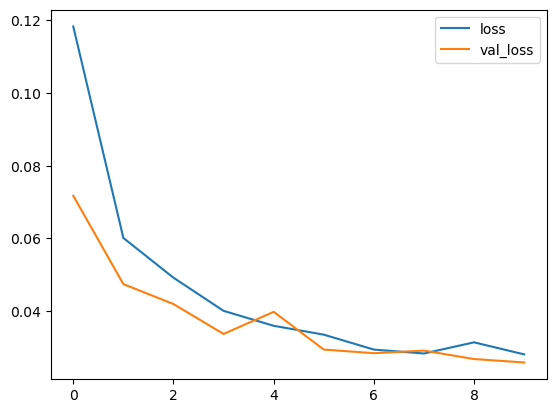

In [26]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [27]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [28]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 5510,  921, ...,    0,    0,    0], dtype=int64)>

In [29]:
np.expand_dims(input_text, 0)

array([[   7, 5510,  921, ...,    0,    0,    0]], dtype=int64)

In [30]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


In [31]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [32]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [33]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [34]:
res.shape

(1, 6)

# 4. Evaluate Model

In [35]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [38]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9113573431968689, Recall:0.8523315787315369, Accuracy:0.5099999904632568


# 5. Test and Gradio

In [39]:
!pip install gradio jinja2

In [50]:
import tensorflow as tf
import gradio as gr

In [51]:
model.save('toxicity.keras')

In [52]:
model = tf.keras.models.load_model('toxicity.keras')

In [53]:
tf.__version__

'2.17.0'

In [54]:
input_str = vectorizer('hey i freaken hate you!')

In [55]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


In [56]:
res

array([[9.3749660e-01, 4.6976528e-04, 9.0037584e-02, 9.4328718e-03,
        1.4966914e-01, 9.8300884e-03]], dtype=float32)

In [57]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [58]:
score_comment("I freaking hate you!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


'toxic: True\nsevere_toxic: False\nobscene: False\nthreat: False\ninsult: False\nidentity_hate: False\n'

In [61]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [62]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
